### Chapter7_Queation 6
In this exercise, you will further analyze the <font color="brown">Wage</font> data set considered
throughout this chapter.

In [1]:
from ISLP import load_data
df=load_data("Wage")
print(df.head())

   year  age            maritl      race        education              region  \
0  2006   18  1. Never Married  1. White     1. < HS Grad  2. Middle Atlantic   
1  2004   24  1. Never Married  1. White  4. College Grad  2. Middle Atlantic   
2  2003   45        2. Married  1. White  3. Some College  2. Middle Atlantic   
3  2003   43        2. Married  3. Asian  4. College Grad  2. Middle Atlantic   
4  2005   50       4. Divorced  1. White       2. HS Grad  2. Middle Atlantic   

         jobclass          health health_ins   logwage        wage  
0   1. Industrial       1. <=Good      2. No  4.318063   75.043154  
1  2. Information  2. >=Very Good      2. No  4.255273   70.476020  
2   1. Industrial       1. <=Good     1. Yes  4.875061  130.982177  
3  2. Information  2. >=Very Good     1. Yes  5.041393  154.685293  
4  2. Information       1. <=Good     1. Yes  4.318063   75.043154  


(a) Perform polynomial regression to predict <font color="brown">wage</font> using <font color="brown">age</font>. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.

Best degree chosen by CV: 8

ANOVA Results:
   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.518656  2.449930e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.883629  1.683872e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.807838  5.110636e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804558  3.698061e-01
5    2993.0  4.766389e+06      1.0    3932.257557    2.466726  1.163856e-01
6    2993.0  4.764599e+06     -0.0    1790.481758        -inf           NaN
7    2993.0  4.764136e+06     -0.0     462.465362        -inf           NaN
8    2993.0  4.764981e+06     -0.0    -844.224297         inf           NaN
9    2993.0  4.771202e+06     -0.0   -6221.494535         inf           NaN


/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/ML/virtual/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


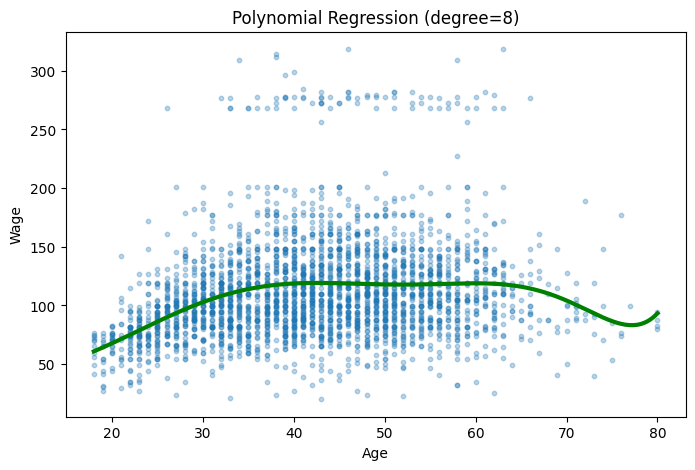

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data

df = load_data("Wage")
X = df[['age']]
y = df['wage']

# ---------------------------------------------------------
# (a) Polynomial regression with cross-validation
# ---------------------------------------------------------

degrees = range(1, 11)
cv_errors = []

kf = KFold(n_splits=10, shuffle=True, random_state=0)

for d in degrees:
    poly = PolynomialFeatures(d, include_bias=False)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    # Negative MSE -> multiply by -1
    mse = -cross_val_score(model, X_poly, y, cv=kf,
                           scoring='neg_mean_squared_error').mean()
    cv_errors.append(mse)

best_degree = degrees[np.argmin(cv_errors)]
print("Best degree chosen by CV:", best_degree)

# ---------------------------------------------------------
# ANOVA comparison
# Fit nested polynomial models using statsmodels
# ---------------------------------------------------------

models = []
for d in degrees:
    poly = PolynomialFeatures(d, include_bias=False)
    X_poly = poly.fit_transform(X)
    X_poly_sm = sm.add_constant(X_poly)
    model = sm.OLS(y, X_poly_sm).fit()
    models.append(model)

anova_results = sm.stats.anova_lm(*models, typ=1)
print("\nANOVA Results:")
print(anova_results)

# ---------------------------------------------------------
# Plot the best polynomial fit
# ---------------------------------------------------------
poly = PolynomialFeatures(best_degree, include_bias=False)
X_poly = poly.fit_transform(X)

model = LinearRegression().fit(X_poly, y)

# Create smooth curve
age_grid = np.linspace(df.age.min(), df.age.max(), 300).reshape(-1, 1)
age_poly = poly.transform(age_grid)
pred = model.predict(age_poly)

plt.figure(figsize=(8, 5))
plt.scatter(df.age, df.wage, alpha=0.3, s=10)
plt.plot(age_grid, pred, linewidth=3, color="green")
plt.title(f"Polynomial Regression (degree={best_degree})")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.show()


(b) Fit a step function to predict <font color="brown">wage</font> using <font color="brown">age</font>, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.

Best number of cuts chosen by CV: 8


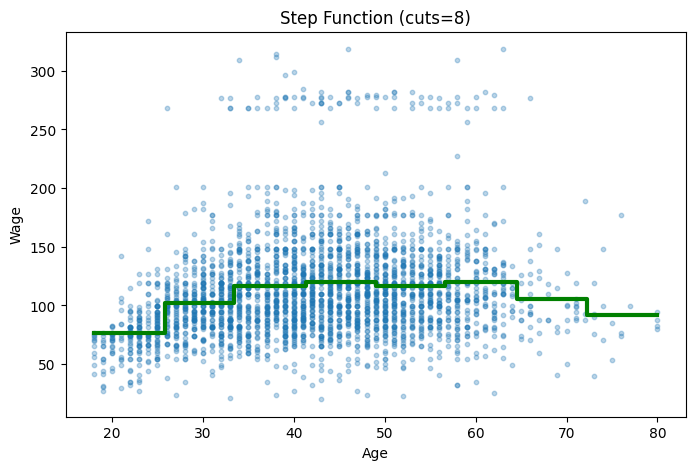

In [7]:
from pandas.api.types import CategoricalDtype

# ---------------------------------------------------------
# (b) Step function + CV
# ---------------------------------------------------------

cuts_list = range(2, 11)
cv_errors_step = []

for k in cuts_list:
    df[f'bin_{k}'] = pd.cut(df.age, bins=k)
    
    X_step = pd.get_dummies(df[f'bin_{k}'])
    model = LinearRegression()
    
    mse = -cross_val_score(model, X_step, y, cv=kf,
                           scoring='neg_mean_squared_error').mean()
    cv_errors_step.append(mse)

best_cuts = cuts_list[np.argmin(cv_errors_step)]
print("Best number of cuts chosen by CV:", best_cuts)

# Fit final step model
df['best_bin'] = pd.cut(df.age, bins=best_cuts)
X_step = pd.get_dummies(df['best_bin'])
model_step = LinearRegression().fit(X_step, y)

# Plot step function
age_grid = np.linspace(df.age.min(), df.age.max(), 300)
grid_bins = pd.cut(age_grid, bins=best_cuts)
grid_dummies = pd.get_dummies(grid_bins)

# Align columns
grid_dummies = grid_dummies.reindex(columns=X_step.columns, fill_value=0)

pred_step = model_step.predict(grid_dummies)

plt.figure(figsize=(8, 5))
plt.scatter(df.age, df.wage, alpha=0.3, s=10)
plt.step(age_grid, pred_step, where='mid', linewidth=3, color="green")
plt.title(f"Step Function (cuts={best_cuts})")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.show()
